In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.collab import *
from fastai.tabular import *

from fastai.vision import *
import pandas as pd
import numpy as np

import pdb
import torch

### Data set

In [3]:
path = Path('/home/fvadell/trabajo/recs/ml-latest-small')
path.ls()

[PosixPath('/home/fvadell/trabajo/recs/ml-latest-small/links.csv'),
 PosixPath('/home/fvadell/trabajo/recs/ml-latest-small/README.txt'),
 PosixPath('/home/fvadell/trabajo/recs/ml-latest-small/ratings.csv'),
 PosixPath('/home/fvadell/trabajo/recs/ml-latest-small/movies.csv'),
 PosixPath('/home/fvadell/trabajo/recs/ml-latest-small/tags.csv')]

In [4]:
ratings = pd.read_csv(path/'ratings.csv')
ratings['y'] = ratings.rating.apply(str)
ratings['user'] = ratings['userId'].apply(lambda x:str(int(x))).astype('category')
ratings['item'] = ratings['movieId'].apply(lambda x:str(int(x))).astype('category')
ratings.head()

,userId,movieId,rating,timestamp,y,user,item
0,1,1,4.0,964982703,4.0,1,1
1,1,3,4.0,964981247,4.0,1,3
2,1,6,4.0,964982224,4.0,1,6
3,1,47,5.0,964983815,5.0,1,47
4,1,50,5.0,964982931,5.0,1,50


### Mini EDA

In [5]:
# (Cantidad de users, Cantidad de películas)
ratings.userId.unique().shape[0],ratings.movieId.unique().shape[0]

(610, 9724)

In [6]:
ratings.rating.value_counts()

4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: rating, dtype: int64

In [7]:
print("Cantidad de ratings: ", ratings.rating.shape[0])

Cantidad de ratings:  100836


In [8]:
print("Accuracy base: ", 26818 / 100836)

Accuracy base:  0.2659566028005871


### Definición y entrenamiento del modelo

In [9]:
CollabDataBunch??

In [9]:
# Por default toma user, item y rating en la primer, segunda y tercer columna respectivamente
data = CollabDataBunch.from_df(ratings[['userId','movieId','rating']], valid_pct = 0.1)

In [10]:
# cuando se crea el DataBunch pierdo la columna de timestamp
data.show_batch()

userId,movieId,target
177,6787,3.0
230,55553,1.0
599,373,3.0
28,1953,4.0
290,1633,4.0


In [11]:
emb_szs = {
  "userId": 50,
  "movieId": 100,
}

In [12]:
#data = CollabDataBunch.from_df(ratings[['user','movieId','rating']], valid_pct = 0.1)
y_range = [0, 5.5]
learn_small = collab_learner(data, emb_szs=emb_szs, 
                             use_nn = True, emb_drop= .3, 
                             layers = [50, 10, 10], 
                             y_range=y_range)

In [13]:
learn_small.metrics=[r2_score]

### Callbacks

##### Vemos la estructura de un Callback

In [14]:
Callback??

##### Vemos el fit

In [15]:
fit??

In [16]:
loss_batch??

In [17]:
callbacks.EarlyStoppingCallback??

##### Modificación del Early Stopping

In [22]:
class EarlyStoppingFede(callbacks.TrackerCallback):
    valid_track = []
    "A `TrackerCallback` that terminates training when monitored quantity stops improving."
    def __init__(self, learn:Learner, monitor:str='valid_loss', mode:str='auto', min_delta:int=0, patience:int=0):
        super().__init__(learn, monitor=monitor, mode=mode)
        self.min_delta,self.patience = min_delta,patience
        if self.operator == np.less:  self.min_delta *= -1

    def on_train_begin(self, **kwargs:Any)->None:
        "Initialize inner arguments."
        self.wait = 0
        self.valid_track = []
        super().on_train_begin(**kwargs)

    def on_epoch_end(self, epoch, **kwargs:Any)->None:
        "Compare the value monitored to its best score and maybe stop training."
        current = self.get_monitor_value()
        if current is None: return
        self.valid_track.append(current)
        print("")
        print("current: ", current)
        print("current - delta: ", current - self.min_delta)
        print("best: ", self.best)
        if self.operator(current - self.min_delta, self.best):
            self.best,self.wait = current,0
            print("Esto viene bien...")
        else:
            self.wait += 1
            print("Hmmmm... sigamos un poco...")
            if self.wait > self.patience:
                print(f'Epoch {epoch}: early stopping')
                print("Bueno, ya!")
                return {"stop_training":True}
            
    def on_train_end(self, **kwargs:Any)->None:
        "Useful for cleaning up things and saving files/models."
        print(" ")
        plt.plot(self.valid_track)
        plt.grid()
        plt.xlabel("Epoch")
        plt.ylabel("Validation loss")

##### Custom Callback

In [23]:
class TestCallback(Callback):
    def __init__(self, learn: Learner):
        super().__init__()
        self.learn = learn
    
    def on_train_begin(self, **kwargs:Any)->None:
        super().on_train_begin(**kwargs)
        self.n_iters = 0
        #pdb.set_trace()
        
    def on_epoch_end(self, epoch, **kwargs:Any)->None:
        self.n_iters += 1
        print("testCb: Fin de la epoch " ,self.n_iters)
        if self.n_iters>=10: self.learn.stop = True
            
    def on_train_end(self, **kwargs:Any)->None:
        print(" ")
        print("TestCallBack: ¡Gracias por todo! Cantidad de epochs corridas: ", self.n_iters)

In [24]:
testCb = TestCallback(learn = learn_small)
earlyFede = EarlyStoppingFede(learn_small, min_delta = 0.005, patience = 3)

## Modelo de Red Neuronal Collaborative Filtering

##### Entrenamos el modelo

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-02
Min loss divided by 10: 7.59E-02


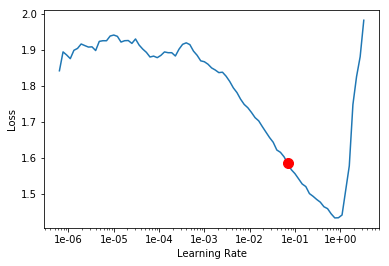

In [103]:
learn_small.lr_find()
learn_small.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,r2_score,time
0,0.819553,0.822713,0.225981,00:25
1,0.740443,0.772455,0.276265,00:37
2,0.704044,0.733313,0.309500,00:32



current:  0.8227134
current - delta:  0.8277133750915527
best:  inf
Esto viene bien...
testCb: Fin de la epoch  1

current:  0.77245474
current - delta:  0.7774547386169434
best:  0.8227134
Esto viene bien...
testCb: Fin de la epoch  2

current:  0.73331296
current - delta:  0.7383129644393921
best:  0.77245474
Esto viene bien...
testCb: Fin de la epoch  3
 
 
TestCallBack: ¡Gracias por todo! Cantidad de epochs corridas:  3


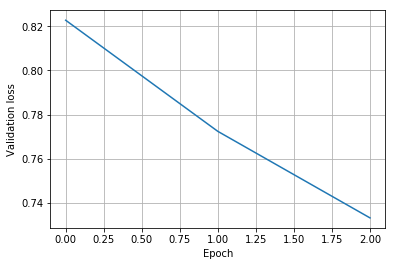

In [104]:
learn_small.fit_one_cycle(3, 6.31E-02, callbacks = [earlyFede, testCb])

##### Predicciones

In [20]:
predicciones_small = learn_small.get_preds(ds_type=DatasetType.Valid)

In [18]:
def create_pred_df(valid_ds, predicciones):
    aux = []
    count = 0
    for user_movie,valor,predic in zip(data.valid_ds.x,
                                       data.valid_ds.y,
                                       predicciones[0].tolist()):
        userId = str(user_movie).split(";")[0][7:]
        movieId = str(user_movie).split(";")[1][9:]
        aux.append([userId, movieId, float(str(valor)), predic[0]])
        count = count +1
    df = pd.DataFrame(aux)
    df.columns = ["userId", "movieId", "rating", "pred"]
    return df

In [21]:
preds_df_small = create_pred_df(data.valid_ds, predicciones_small)
#df['c'] = df.apply(lambda row: row.a + row.b, axis=1)
preds_df_small['error'] = preds_df_small.apply(lambda row: row.pred - row.rating, axis=1)
preds_df_small.head()

NameError: name 'predicciones_small' is not defined

In [30]:
def errors_acum(df, th, inverse = False):
    if (inverse):
        return len(df[df['error']>th])+len(df[df['error']<-th])
    return len(df[(df['error']<=th)&(df['error']>=-th)])

In [31]:
def errors(acums, l):
    stats = {
        '<0.25': acums['<0.25']*100//l,
        '<0.5': (acums['<0.5']-acums['<0.25'])*100//l,
        '<1': (acums['<1']-acums['<0.5'])*100//l,
        '<1.5': (acums['<1.5']-acums['<1'])*100//l,
        '<2': (acums['<2']-acums['<1.5'])*100//l,
        '>2': acums['>2']*100//l
    }
    return stats

In [24]:
acums = {
    '<0.25': errors_acum(preds_df_small, 0.25),
    '<0.5': errors_acum(preds_df_small, 0.5),
    '<1': errors_acum(preds_df_small, 1),
    '<1.5': errors_acum(preds_df_small, 1.5),
    '<2': errors_acum(preds_df_small, 2),
    '>2': errors_acum(preds_df_small,2,inverse=True)
}
stats = errors(acums, len(preds_df_small))

NameError: name 'preds_df_small' is not defined

{'<0.25': 25, '<0.5': 22, '<1': 30, '<1.5': 13, '<2': 4, '>2': 2}


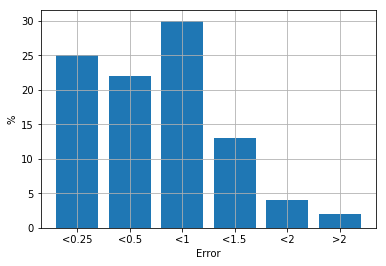

In [26]:
import matplotlib.pyplot as plt

plt.bar(range(len(stats)), list(stats.values()), align='center')
plt.xticks(range(len(stats)), list(stats.keys()))
plt.xlabel('Error')
plt.grid()
plt.ylabel('%')
print(stats)

## Modelo de Red Neuronal Tabular

In [14]:
#me armo un validation set. Llamo "lista" a los índices del validation set

#ratings.shape[0] es la cantidad de datos

lista = list(ratings.sample(int(ratings.shape[0]*.10)).reset_index()['index'])

In [15]:
data_tab = TabularDataBunch.from_df('.',ratings[['user','item','y']],
                 cat_names=['user','item'],
                 dep_var='y', valid_idx = lista, bs = 500)

In [16]:
data_tab.show_batch()

user,item,target
303,32,3.5
318,73321,3.5
217,1377,3.0
4,2109,4.0
200,8641,3.0


##### Definimos una red neuronal con la misma cantidad de capas y tamaño de embeddings pero tabular

In [17]:
emb_szs_str = {
  "user": 50,
  "item": 100,
}

In [18]:
learn_tab = tabular_learner(data_tab, 
                            layers=[5, 2, 10], 
                            emb_szs=emb_szs_str, 
                            metrics=accuracy)

In [4]:
tabular_learner??

In [5]:
Learner??

In [19]:
learn_tab.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(611, 50)
    (1): Embedding(9725, 100)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=150, out_features=5, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=5, out_features=2, bias=True)
    (4): ReLU(inplace=True)
    (5): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=2, out_features=10, bias=True)
    (7): ReLU(inplace=True)
    (8): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=10, out_features=10, bias=True)
  )
)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-02
Min loss divided by 10: 7.59E-02


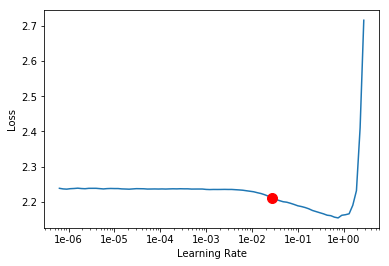

In [20]:
learn_tab.lr_find()
learn_tab.recorder.plot(suggestion=True)

##### Instanciamos otro early stopping pero esta vez para que monitoree el accuracy. Si no aclaramos nada va a monitorear el valid loss, que en este caso es Cross Entropy

In [25]:
earlyFede_tab = EarlyStoppingFede(learn_tab, min_delta = 0.0005, patience = 3, monitor = "accuracy")

epoch,train_loss,valid_loss,accuracy,time
0,2.008401,10.948786,0.016463,00:05
1,2.003197,11.312585,0.270455,00:05
2,2.002905,34.490650,0.056928,00:05
3,2.002292,13.954838,0.193593,00:05
4,1.997815,15.346251,0.193593,00:05



current:  tensor(0.0165)
current - delta:  tensor(0.0160)
best:  -inf
Esto viene bien...
testCb: Fin de la epoch  1

current:  tensor(0.2705)
current - delta:  tensor(0.2700)
best:  tensor(0.0165)
Esto viene bien...
testCb: Fin de la epoch  2

current:  tensor(0.0569)
current - delta:  tensor(0.0564)
best:  tensor(0.2705)
Hmmmm... sigamos un poco...
testCb: Fin de la epoch  3

current:  tensor(0.1936)
current - delta:  tensor(0.1931)
best:  tensor(0.2705)
Hmmmm... sigamos un poco...
testCb: Fin de la epoch  4

current:  tensor(0.1936)
current - delta:  tensor(0.1931)
best:  tensor(0.2705)
Hmmmm... sigamos un poco...
testCb: Fin de la epoch  5

current:  tensor(0.1936)
current - delta:  tensor(0.1931)
best:  tensor(0.2705)
Hmmmm... sigamos un poco...
Epoch 5: early stopping
Bueno, ya!
testCb: Fin de la epoch  6
 
 
TestCallBack: ¡Gracias por todo! Cantidad de epochs corridas:  6


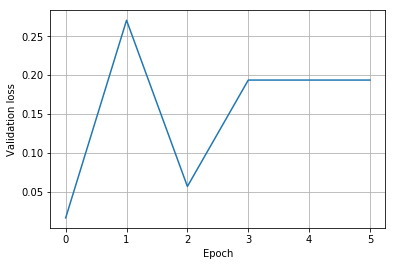

In [26]:
learn_tab.fit_one_cycle(15, 8.03E-02, callbacks = [earlyFede_tab, testCb])

In [42]:
learn_tab.save('Learn_tabWeights')

In [27]:
n=0

x,y = learn_tab.get_preds(ds_type=DatasetType.Valid)
preds_df_tab = pd.DataFrame(columns=['rating', 'pred', 'error'])

for k,u in enumerate(x.argmax(dim=1)):
    predigo,era = learn_tab.data.classes[u],learn_tab.data.classes[y[k].item()]
    #print(predigo,era)
    error=abs(float(predigo)-float(era))
    aux = [era, predigo, error]
    #print(aux)
    preds_df_tab.loc[k]=aux
    #q+=(float(predigo)-float(era))*(float(predigo)-float(era))
#n=n/y.shape[0]
#q=q/y.shape[0]
print(n)
#print(q)

0


In [28]:
preds_df_tab.head()

,rating,pred,error
0,4.0,3.0,1.0
1,4.0,3.0,1.0
2,4.0,3.0,1.0
3,2.0,3.0,1.0
4,3.0,3.0,0.0


In [32]:
acums_tab = {
    '<0.25': errors_acum(preds_df_tab, 0.26),
    '<0.5': errors_acum(preds_df_tab, 0.51),
    '<1': errors_acum(preds_df_tab, 1.1),
    '<1.5': errors_acum(preds_df_tab, 1.51),
    '<2': errors_acum(preds_df_tab, 2.1),
    '>2': errors_acum(preds_df_tab,2,inverse=True)
}
stats_tab = errors(acums_tab, len(preds_df_tab))

In [33]:
stats_tab

{'<0.25': 19, '<0.5': 18, '<1': 34, '<1.5': 9, '<2': 16, '>2': 1}

{'<0.25': 19, '<0.5': 18, '<1': 34, '<1.5': 9, '<2': 16, '>2': 1}


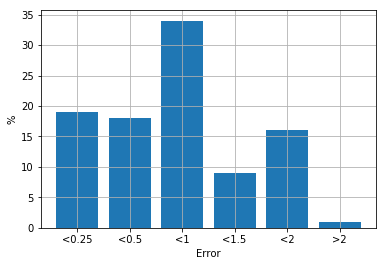

In [34]:
import matplotlib.pyplot as plt

plt.bar(range(len(stats_tab)), list(stats_tab.values()), align='center')
plt.xticks(range(len(stats_tab)), list(stats_tab.keys()))
plt.xlabel('Error')
plt.grid()
plt.ylabel('%')
print(stats_tab)

## Hooks

#### Probamos el ActivationStats hook, que calcula la media y desvio estandar de cada capa

In [35]:
emb_szs_str = {
  "user": 50,
  "item": 100,
}

In [88]:
tabular_learner??

In [89]:
TabularModel??
# TabularModel crea las capas. Llama a bn_drop_lin para agregar Batch Normalization y DropOut

In [90]:
bn_drop_lin??
# Agrega las capas de BN y Dropout

In [76]:
# Si le mandamos use_bn = True, el método bn_drop_lin agrega las capas de batch normalization
bn = True
learn_tab = tabular_learner(data_tab, 
                            layers=[5, 2, 10], 
                            emb_szs=emb_szs_str, 
                            metrics=accuracy,
                            use_bn = bn)

In [37]:
callbacks.ActivationStats??

In [203]:
callbacks.HookCallback??

In [77]:
earlyFede_tab = EarlyStoppingFede(learn_tab, min_delta = 0.0005, patience = 3, monitor = "accuracy")

##### Vamos a monitorear las capas lineales que están en las posiciones 0, 3, 6 y 9 que son las capas 

In [78]:
learn_tab.model.layers

Sequential(
  (0): Linear(in_features=150, out_features=5, bias=True)
  (1): ReLU(inplace=True)
  (2): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Linear(in_features=5, out_features=2, bias=True)
  (4): ReLU(inplace=True)
  (5): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Linear(in_features=2, out_features=10, bias=True)
  (7): ReLU(inplace=True)
  (8): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Linear(in_features=10, out_features=10, bias=True)
)

#### Armo el hook ActivationStats y le pido que lo aplique sobre las capas lineales, la 0, 3, 6 y 9

In [79]:
if bn:
    activation_stats_cb = callbacks.ActivationStats(learn_tab, [learn_tab.model.layers[1], learn_tab.model.layers[4], learn_tab.model.layers[7]])
else:
    activation_stats_cb = callbacks.ActivationStats(learn_tab, [learn_tab.model.layers[1], learn_tab.model.layers[2], learn_tab.model.layers[4]])

In [80]:
testCb = TestCallback(learn = learn_tab)

epoch,train_loss,valid_loss,accuracy,time
0,2.483534,2.451098,0.117326,00:05
1,2.343476,2.324942,0.148666,00:04
2,2.194114,2.191892,0.274422,00:05
3,2.041016,2.065166,0.308043,00:05
4,1.921875,1.965239,0.319151,00:04
5,1.834282,1.917879,0.322821,00:05
6,1.766066,1.867094,0.326986,00:05
7,1.715781,1.849091,0.327284,00:05
8,1.679170,1.832629,0.326986,00:05
9,1.646100,1.832571,0.329465,00:05



current:  tensor(0.1173)
current - delta:  tensor(0.1168)
best:  -inf
Esto viene bien...
testCb: Fin de la epoch  1

current:  tensor(0.1487)
current - delta:  tensor(0.1482)
best:  tensor(0.1173)
Esto viene bien...
testCb: Fin de la epoch  2

current:  tensor(0.2744)
current - delta:  tensor(0.2739)
best:  tensor(0.1487)
Esto viene bien...
testCb: Fin de la epoch  3

current:  tensor(0.3080)
current - delta:  tensor(0.3075)
best:  tensor(0.2744)
Esto viene bien...
testCb: Fin de la epoch  4

current:  tensor(0.3192)
current - delta:  tensor(0.3187)
best:  tensor(0.3080)
Esto viene bien...
testCb: Fin de la epoch  5

current:  tensor(0.3228)
current - delta:  tensor(0.3223)
best:  tensor(0.3192)
Esto viene bien...
testCb: Fin de la epoch  6

current:  tensor(0.3270)
current - delta:  tensor(0.3265)
best:  tensor(0.3228)
Esto viene bien...
testCb: Fin de la epoch  7

current:  tensor(0.3273)
current - delta:  tensor(0.3268)
best:  tensor(0.3270)
Hmmmm... sigamos un poco...
testCb: Fin 

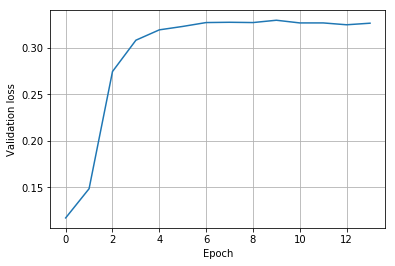

In [81]:
learn_tab.fit_one_cycle(15, 3.63E-04, callbacks = [earlyFede_tab, testCb, activation_stats_cb])

#### La variable stats es un tensor que tiene dos variables (mean, std), luego tiene la cantidad de layers, y por última la cantidad de batches

In [82]:
# La información sobre la media y el desvío estándar queda en
# learner.<nombre del hook>.stats
learn_tab.activation_stats.stats.shape

torch.Size([2, 3, 2534])

In [83]:
learn_tab.activation_stats.stats[0][0][:10]

tensor([0.0232, 0.0233, 0.0232, 0.0234, 0.0232, 0.0231, 0.0233, 0.0233, 0.0232,
        0.0232])

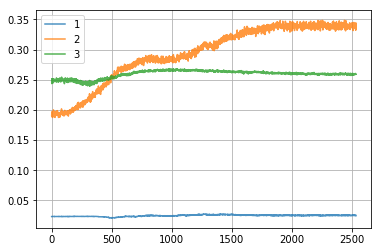

In [84]:
plt.plot(learn_tab.activation_stats.stats[0][0].numpy(), alpha = .8, label = '1')
plt.plot(learn_tab.activation_stats.stats[0][1].numpy(), alpha = .8, label = '2')
plt.plot(learn_tab.activation_stats.stats[0][2].numpy(), alpha = .8, label = '3')
#plt.plot(learn_tab.activation_stats.stats[0][3].numpy(), alpha = .8, label = '4')
plt.grid()
plt.legend()
plt.show()

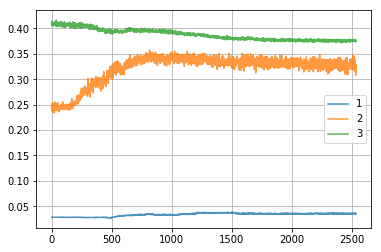

In [85]:
plt.plot(learn_tab.activation_stats.stats[1][0].numpy(), alpha = .8, label = '1')
plt.plot(learn_tab.activation_stats.stats[1][1].numpy(), alpha = .8, label = '2')
plt.plot(learn_tab.activation_stats.stats[1][2].numpy(), alpha = .8, label = '3')
#plt.plot(learn_tab.activation_stats.stats[1][3].numpy(), alpha = .8, label = '4')
plt.legend()
plt.grid()
plt.show()

In [52]:
learn_tab.model??